# EDA 2 & 3

2. Now write a function which returns N entries of cities which have the highest variability in `AverageTemperature` in a specified time range.

3. Plot the temperature development (and uncertainty) over time (aggregate as you see fit) of the top 4 entries of your function for a given time period and save the plot as a `.png` file.


In [1]:
import pandas as pd

In [2]:
cols_subset = ['dt', 
               'AverageTemperature', 
               'AverageTemperatureUncertainty', 
               'City', 
               'Country']

In [3]:
pdf = pd.read_csv('./data/GlobalLandTemperaturesByCity.csv', \
                  parse_dates=['dt'], infer_datetime_format=True, 
                 usecols=cols_subset) \
                .dropna()

In [4]:
pdf.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country
0,1743-11-01,6.068,1.737,Århus,Denmark
5,1744-04-01,5.788,3.624,Århus,Denmark
6,1744-05-01,10.644,1.283,Århus,Denmark
7,1744-06-01,14.051,1.347,Århus,Denmark
8,1744-07-01,16.082,1.396,Århus,Denmark


In [5]:
country_key = 'Country' # 'Country_nr'
city_key = 'City' # 'City_nr'

### Date processing

In [6]:
from datetime import datetime, timedelta

def get_datetime_range(date_str1, date_str2):

    date1 = list(map(int, date_str1.split('-'))) 
    date2 = list(map(int, date_str2.split('-')))     
    
    return [datetime(*date1),datetime(*date2)]

def get_nr_days(date_range):
    
    datediff = dt_range[1]-dt_range[0]
    
    return datediff.days+1

def _get_valid_range(date_range, threshold=0.75):
    
    tot_nr_days = get_nr_days(date_range)
    
    def meth(s):
        
        nr_days = s.size
        
        return nr_days/tot_nr_days >= threshold
    
    return meth

### Variability processing

In [7]:
# Quantile and IQR
qtile = lambda x : np.quantile(x, q=[0.25,0.75])
iqr = lambda x: np.abs(np.diff(qtile(x))[0])

# wrapper function in case want to use some other metric
def _variability_score(fnc):
    
    def meth(s):
    
        return fnc(s.values)
    
    return meth

variability_score = _variability_score(iqr)

In [35]:
# Filter function for the dates

def filter_by_dates(pdf, date_range):
    return pdf[(pdf['dt'] >= date_range[0]) & (pdf['dt'] <= date_range[1])]

In [67]:
def _get_highest_variability(fraction_of_obs=0.75):

    temper_key =  'AverageTemperature'
    
    grouping = [city_key, country_key]
    
    def meth(pdf, N,date_range):
    
        # Filter to the date range
        pdf_ = filter_by_dates(pdf, date_range)
        
        # Check if date range is contains valid number of events
        get_valid_range = _get_valid_range(date_range, fraction_of_obs)

        # Goupy on country and city, compute variability by IQR
        pdf_ =  pdf_.groupby(grouping)\
            .agg({temper_key:variability_score,'dt':get_valid_range})\
            .reset_index()\
            .rename(columns={temper_key:'variability'})
        
        # Get the largest N 
        pdf_ = pdf_[pdf_['dt']].nlargest(N,'variability')\
                    .drop(columns=['dt']) \
                    .reset_index(drop=True)
                
        return pdf_

    return meth

# Declare wrapper with threshold fraction for how full the time range should be
get_highest_variability = _get_highest_variability(0.0)

### Testing

Define an arbitrary date range

In [49]:
dt_range = get_datetime_range('1903-11-01','2013-08-01')

Get the variability

In [50]:
pdf1 = get_highest_variability(pdf, 10, dt_range)

In [51]:
pdf1.head()

,City,Country,variability
0,Hailar,China,31.37000
1,Yakeshi,China,31.37000
2,Kyzyl,Russia,31.27825
3,Blagoveshchensk,Russia,30.60325
4,Heihe,Russia,30.60325


In [52]:
pdf1.head()

,City,Country,variability
0,Hailar,China,31.37000
1,Yakeshi,China,31.37000
2,Kyzyl,Russia,31.27825
3,Blagoveshchensk,Russia,30.60325
4,Heihe,Russia,30.60325


## EDA 3

Get the top 4 cities, and plot

In [53]:
pdfN = get_highest_variability(pdf, 4, dt_range)

In [54]:
pdfN.head()

,City,Country,variability
0,Hailar,China,31.37000
1,Yakeshi,China,31.37000
2,Kyzyl,Russia,31.27825
3,Blagoveshchensk,Russia,30.60325
4,Heihe,Russia,30.60325


In [55]:
cities_list = pdfN.City.tolist()
cities_list.remove('Yakeshi')
print(cities_list)

['Hailar', 'Kyzyl', 'Blagoveshchensk', 'Heihe']


In [70]:
# Get time series for these cities
pdf4 = pdf[pdf[city_key].isin(cities_list) & 
           pdf[country_key].isin(pdfN[country_key].tolist())].copy()
pdf4 = filter_by_dates(pdf4, dt_range)
pdf4.sort_values(by=[country_key, city_key, 'dt'], inplace=True)

In [71]:
# For the legend labels
top4 = pdf4[[country_key,city_key]].drop_duplicates().values

### Plotting

In [72]:
%matplotlib inline

In [73]:
import matplotlib.pyplot as plt

In [74]:
def get_label(df):
    return ", ".join(map(str,df[[city_key,country_key]].drop_duplicates().values[0]))


temper_key =  'AverageTemperature'

def plot_temp(df,timecol, temper_col, markerline, ax):
    
    ax.plot(df[timecol].values, 
            df[temper_col].values, 
            markerline, label=get_label(df))
    return ax

In [75]:
mask1 = (pdf4[country_key] == top4[0,0]) & (pdf4[city_key] == top4[0,1])
mask2 = (pdf4[country_key] == top4[1,0]) & (pdf4[city_key] == top4[1,1])
mask3 = (pdf4[country_key] == top4[2,0]) & (pdf4[city_key] == top4[2,1])
mask4 = (pdf4[country_key] == top4[3,0]) & (pdf4[city_key] == top4[3,1])

In [76]:
pdf4['decade'] = pdf4.dt.apply(lambda x: x.year-x.year%10)

In [77]:
pdf4g = pdf4.groupby([country_key, city_key, 'decade']).agg({temper_key:'mean'})\
    .reset_index() \
    .sort_values(by=[country_key, city_key, 'decade'])

In [78]:
mask1 = (pdf4g[country_key] == top4[0,0]) & (pdf4g[city_key] == top4[0,1])
mask2 = (pdf4g[country_key] == top4[1,0]) & (pdf4g[city_key] == top4[1,1])
mask3 = (pdf4g[country_key] == top4[2,0]) & (pdf4g[city_key] == top4[2,1])
mask4 = (pdf4g[country_key] == top4[3,0]) & (pdf4g[city_key] == top4[3,1])

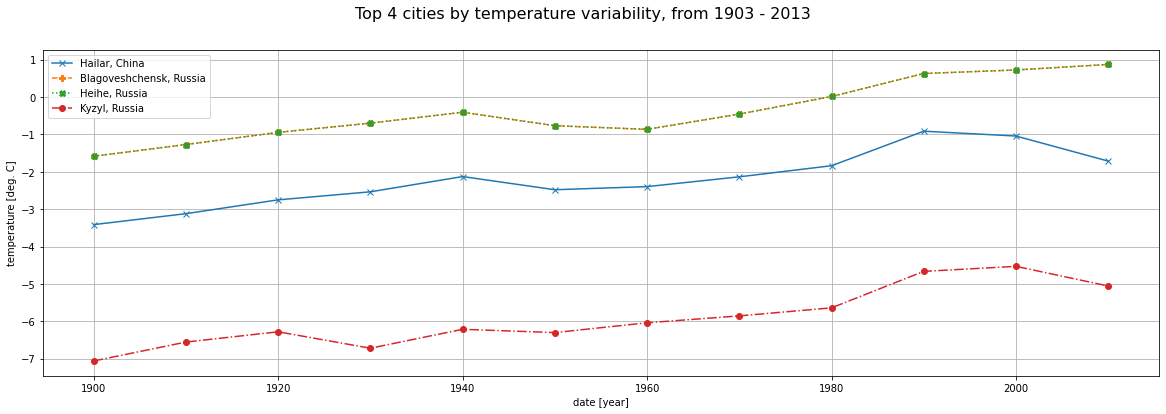

In [79]:
fig, ax = plt.subplots(1,1,figsize=[20,6])

plot_temp(pdf4g[mask1], 'decade', temper_key, 'x-' , ax)
plot_temp(pdf4g[mask2], 'decade', temper_key, 'P--', ax)
plot_temp(pdf4g[mask3], 'decade', temper_key, 'X:' , ax)
plot_temp(pdf4g[mask4], 'decade', temper_key, 'o-.', ax)

plt.xlabel('date [year]')
plt.ylabel('temperature [deg. C]')

fig.suptitle(f'Top 4 cities by temperature variability, from {dt_range[0].year} - {dt_range[1].year}', fontsize=16)

plt.legend();

plt.grid();
fig.savefig('top4_cities_by_temperature_variability.png')